Summary Statistics:
       total_purchases  avg_cart_value  total_time_spent  product_click  \
count       999.000000      999.000000        999.000000     999.000000   
mean         11.539540       74.935896         49.348759      28.093093   
std           6.949156       54.635622         32.730973      16.164124   
min           0.000000       10.260000          5.120000       4.000000   
25%           6.000000       33.350000         22.375000      16.000000   
50%          10.000000       49.380000         40.360000      21.000000   
75%          17.000000      118.490000         77.170000      45.000000   
max          32.000000      199.770000        119.820000      73.000000   

       discount_counts  
count       999.000000  
mean          4.313313  
std           4.532772  
min           0.000000  
25%           1.000000  
50%           2.000000  
75%           8.000000  
max          21.000000  


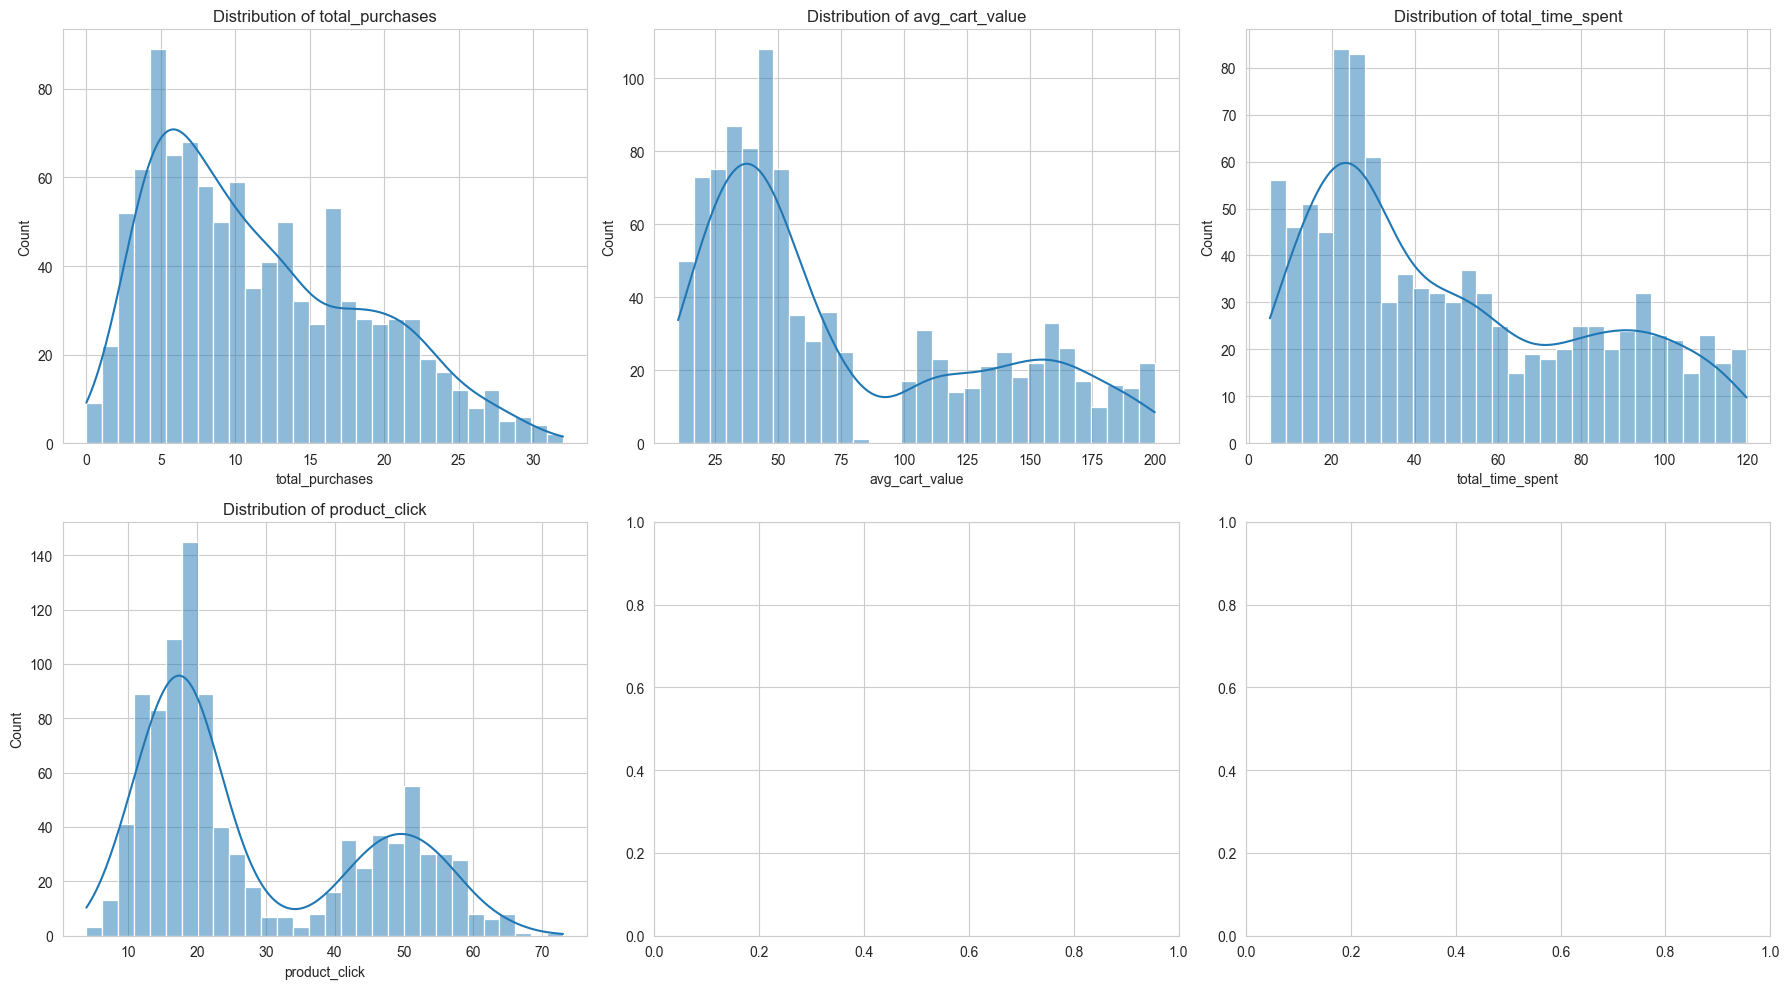

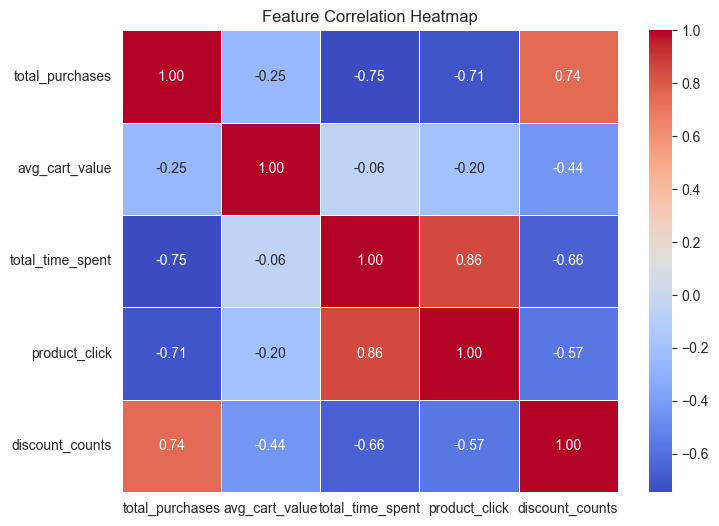

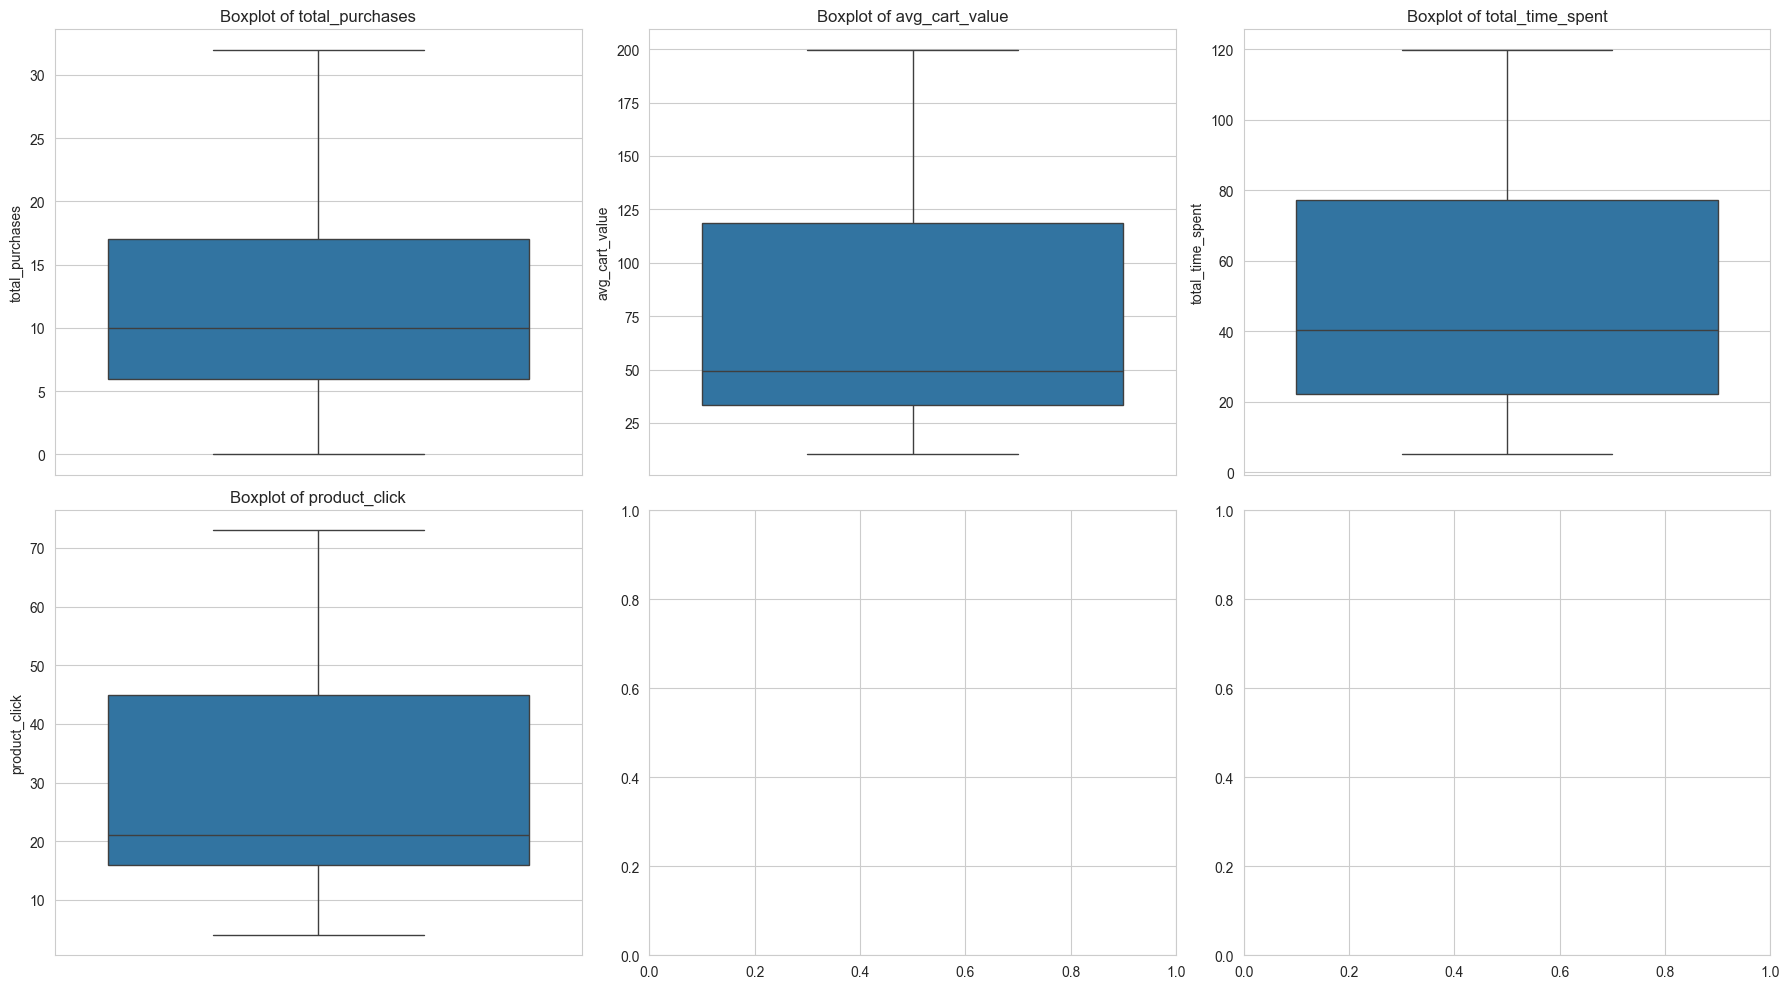

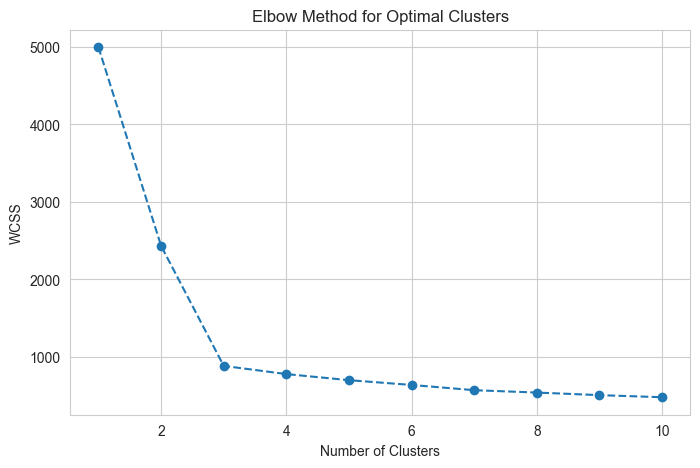

Silhouette Score: 0.613
Davies-Bouldin Index: 0.571


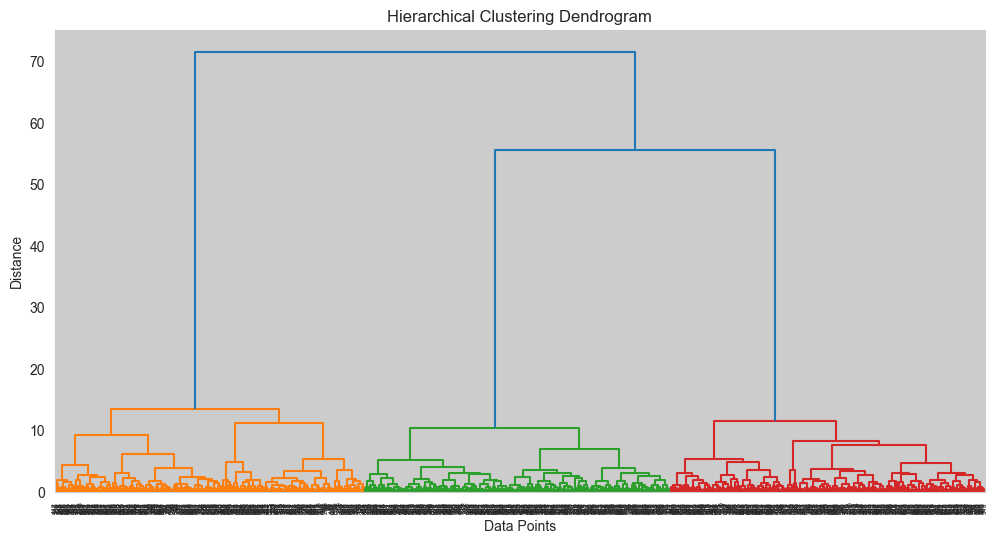

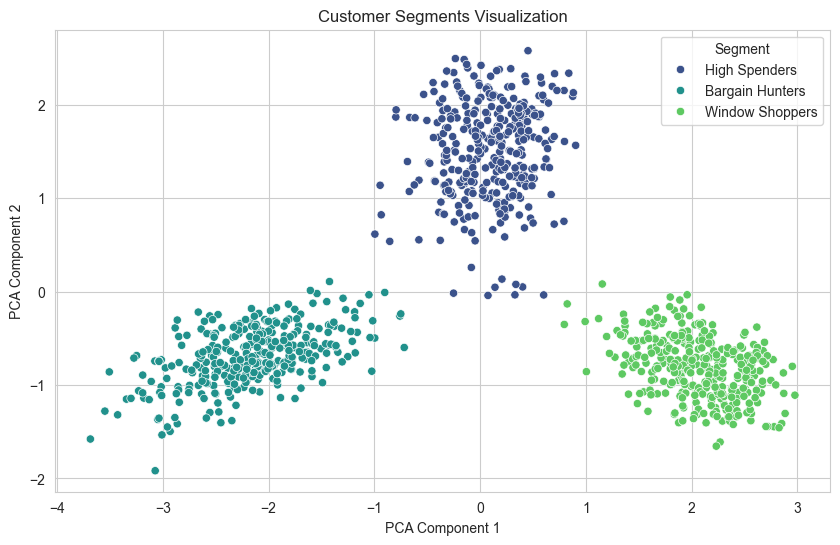

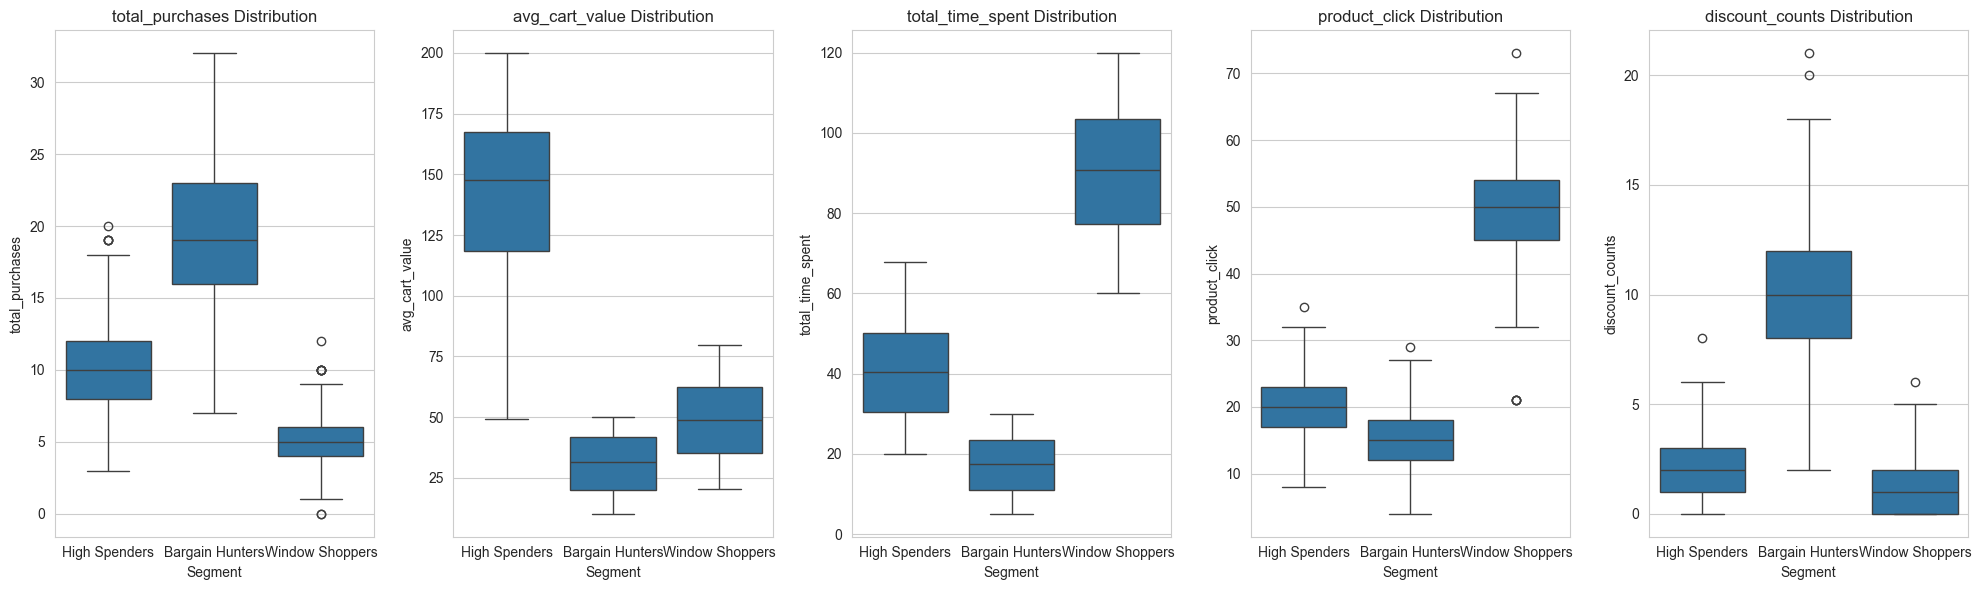

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram


# Load the dataset
file_path = "customer_behavior_analytcis.csv"
df = pd.read_csv(file_path)

# Drop customer_id if present
if "customer_id" in df.columns:
    df.drop(columns=["customer_id"], inplace=True)

# Handle missing values by replacing with median
df.fillna(df.median(numeric_only=True), inplace=True)

# EDA: Summary statistics
print("Summary Statistics:")
print(df.describe())

# Plot distributions of numerical features
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
columns = df.columns[:-1]  # Excluding Cluster column

for i, col in enumerate(columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplots for Outlier Detection
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(columns):
    sns.boxplot(data=df, y=col, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Normalize the data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=["Cluster"], errors="ignore"))

# Determine optimal clusters using Elbow Method
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Apply KMeans Clustering (Assuming 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Evaluate Clustering Model
silhouette_avg = silhouette_score(df_scaled, df["Cluster"])
db_index = davies_bouldin_score(df_scaled, df["Cluster"])

print(f"Silhouette Score: {silhouette_avg:.3f}")  # Higher is better
print(f"Davies-Bouldin Index: {db_index:.3f}")  # Lower is better

# Hierarchical Clustering Dendrogram
plt.figure(figsize=(12, 6))
linked = linkage(df_scaled, method="ward")
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Reduce Dimensions Using PCA for Visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df["PCA1"], df["PCA2"] = df_pca[:, 0], df_pca[:, 1]

# Assign cluster labels based on feature characteristics
cluster_mapping = {}
for cluster in df["Cluster"].unique():
    subset = df[df["Cluster"] == cluster]
    if subset["total_purchases"].mean() > 10 and subset["discount_counts"].mean() > 5:
        cluster_mapping[cluster] = "Bargain Hunters"
    elif subset["avg_cart_value"].mean() > 100 and subset["discount_counts"].mean() < 2:
        cluster_mapping[cluster] = "High Spenders"
    else:
        cluster_mapping[cluster] = "Window Shoppers"

df["Segment"] = df["Cluster"].map(cluster_mapping)

# Scatter Plot of Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Segment"], palette="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segments Visualization")
plt.legend(title="Segment")
plt.show()

# Boxplots to visualize feature differences among segments
features = ["total_purchases", "avg_cart_value", "total_time_spent", "product_click", "discount_counts"]
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, col in enumerate(features):
    sns.boxplot(x=df["Segment"], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} Distribution")

plt.tight_layout()
plt.show()
